In [1]:
import ast
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike
from scipy.stats import chi2_contingency
from pathlib import Path
from collections import defaultdict

### Import Data
The pickle is a df, and this steop turns it into a dictionary

In [2]:
# Load the DataFrame using pandas
rce3_alone_clusters = pd.read_pickle("rce_pilot_3_alone_comp_cluster_ranges.pkl")

# Initialize the dictionary
timestamp_dicts = {}

# Loop through each row of the DataFrame to populate the dictionary
for index, row in rce3_alone_clusters.iterrows():
    # Define the key as a combination of session_dir and current_subject
    key = f"{row['session_dir']}"

    start_pos = key.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    key_without_suffix = key[:end_pos]
    
    # Initialize nested dictionary for this key if not already present
    if key not in timestamp_dicts:
        timestamp_dicts[key_without_suffix] = {}

    # Loop through the cluster_timestamps_ranges_dict to populate conditions
    for condition, ranges in row['cluster_timestamps_ranges_dict'].items():
        # Check if the condition key already exists, if not initialize a list
        if condition not in timestamp_dicts[key_without_suffix]:
            timestamp_dicts[key_without_suffix][str(condition)] = []

        # Extend the existing list with new ranges
        modified_ranges = [(start // 20, end // 20) for start, end in ranges]
        timestamp_dicts[key_without_suffix][str(condition)].extend(modified_ranges)

# Optionally, convert the lists to numpy arrays as in your previous code
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

### Remove Some Noise
If a cluster shifts to another cluster for 5ms and then back to the original cluster, that's more like noise than actual useful clustering of behavioral data. This next step first combines intervals that are less than 250 ms apart, and then removes any remaining cluster that is less than 250 ms long.

In [3]:
def combine_intervals(ranges):
    """Combine intervals that are within 250 milliseconds of each other."""
    if ranges.size == 0:
        return ranges
    # Sort ranges based on the start times
    sorted_ranges = np.array(sorted(ranges, key=lambda x: x[0]))
    combined = [sorted_ranges[0]]

    for current in sorted_ranges[1:]:
        last = combined[-1]
        # If the current start is within 250 ms of the last end, combine them
        if current[0] - last[1] <= 250:
            combined[-1] = [last[0], max(last[1], current[1])]
        else:
            combined.append(current)

    return np.array(combined)

def remove_short_intervals(ranges):
    """Remove intervals that are less than 250 milliseconds long."""
    return np.array([interval for interval in ranges if interval[1] - interval[0] >= 250])

def process_timestamps_nested(timestamp_dicts):
    timestamp_dicts_cut = {}
    for date_key, clusters in timestamp_dicts.items():
        timestamp_dicts_cut[date_key] = {}
        for cluster_key, intervals in clusters.items():
            intervals = np.array(intervals)  # Ensure intervals is a numpy array
            if intervals.size > 0 and intervals.ndim == 2:  # Check if there are any intervals and it's 2-dimensional
                combined = combine_intervals(intervals)
                cleaned = remove_short_intervals(combined)
                timestamp_dicts_cut[date_key][cluster_key] = cleaned
            else:
                timestamp_dicts_cut[date_key][cluster_key] = np.array([])  # Handle empty or malformed input case
    return timestamp_dicts_cut

# Assuming timestamp_dicts is defined and filled with your data
timestamp_dicts_cut = process_timestamps_nested(timestamp_dicts)

### Fit Clusters to Windows
The dictionary currently lists the timestamp of each cluster's start & stop time, but it the clustering was only done in 30-second windows (10s before event, 10s event, 10s post event). This step keeps each window separate, so we don't count it as a transition if it happened in different windows.

The windows are created by finding the lowest number, adding 30,100 ms to it, grouping everything within that range as 1 window, and then finding the next lowest number and doing that again until there are no more windows.

In [18]:
def find_next_window(start_time, all_timestamps, all_ranges, gap):
    # Find the next start time that is greater than the given start_time
    next_start = min([t for t in all_timestamps if t > start_time], default=None)
    if next_start is None:
        return None, None
    
    # Determine the maximum end time that doesn't exceed next_start + gap
    potential_ends = [end for start, end in all_ranges if start >= next_start and end <= next_start + gap]
    if not potential_ends:
        return next_start, next_start + gap  # Extend to the full window length if no end within range
    next_end = max(potential_ends)
    return next_start, next_end

# Process each recording in timestamp_dicts_cut
windowed_events = {}

for recording_key, clusters in timestamp_dicts_cut.items():
    # Prepare data arrays
    all_ranges = []
    all_cluster_ids = []
    for cluster_id, times in clusters.items():
        for start_end in times:
            all_ranges.append(start_end)
            all_cluster_ids.append(cluster_id)
    
    all_starts = np.array([r[0] for r in all_ranges])
    all_ends = np.array([r[1] for r in all_ranges])
    
    # Sort ranges by start times for processing order
    sorted_indices = np.argsort(all_starts)
    all_starts = all_starts[sorted_indices]
    all_ends = all_ends[sorted_indices]
    all_cluster_ids = [all_cluster_ids[i] for i in sorted_indices]
    
    # Initialize windows
    min_timestamp = all_starts.min()
    dynamic_windows = [(min_timestamp, min(min_timestamp + 30000, all_ends.max()))]
    
    # Find subsequent windows
    current_end = dynamic_windows[-1][1]
    while True:
        next_start, next_end = find_next_window(current_end, all_starts, list(zip(all_starts, all_ends)), 30100)
        if next_start is None:
            break
        dynamic_windows.append((next_start, next_end))
        current_end = next_end

    # Map clusters to windows
    windows_dict = {}
    for window_num, (window_start, window_end) in enumerate(dynamic_windows):
        clusters_in_window = []
        for idx, (start, end) in enumerate(zip(all_starts, all_ends)):
            if start >= window_start and end <= window_end and all_cluster_ids[idx] != '4':  # The last and statement removes cluster '4' because only 1 occurs so far
                clusters_in_window.append(all_cluster_ids[idx])
        
        if clusters_in_window:  # Only store windows with data
            windows_dict[f"Window {window_num + 1}"] = clusters_in_window

    windowed_events[recording_key] = windows_dict

### Merge Consecutive Clusters and Iterate Over Each Recording
If a window looked like ['1', '2', '2', '3'] it would be changed to ['1', '2', '3'] since clusters can't transition to themselves

In [19]:
# Create a new dictionary to store the merged window events
windowed_events_merged = {}

# Loop through each recording
for recording_key, windows in windowed_events.items():
    # Prepare a sub-dictionary for the current recording
    windowed_events_merged[recording_key] = {}
    
    # Loop through each window in the current recording
    for window_key, clusters in windows.items():
        # Initialize a new list to store clusters without consecutive duplicates
        filtered_clusters = []
        
        # Iterate through the list of clusters in the current window
        previous_cluster = None
        for cluster in clusters:
            if cluster != previous_cluster:
                filtered_clusters.append(cluster)
                previous_cluster = cluster
        
        # Assign the filtered list of clusters to the current window in the merged dictionary
        windowed_events_merged[recording_key][window_key] = filtered_clusters

### Count the Occurrence of Each Cluster
This will give us the expected transition probability

In [20]:
cluster_counts = {}

for recording in windowed_events_merged.values():
    for clusters in recording.values():
        # Skip the first cluster in each list
        for cluster_id in clusters[1:]:  # Start from the second item in the list
            if cluster_id in cluster_counts:
                cluster_counts[cluster_id] += 1
            else:
                cluster_counts[cluster_id] = 1  # Initialize if not present

In [21]:
cluster_counts

{'5': 586, '1': 413, '2': 484, '6': 186, '7': 338, '3': 422, '0': 100}

In [22]:
sorted_cluster_counts = {key: cluster_counts[key] for key in sorted(cluster_counts)}
sorted_cluster_counts

{'0': 100, '1': 413, '2': 484, '3': 422, '5': 586, '6': 186, '7': 338}

## Create Observed Transition Count Matrix

In [23]:
def count_transitions(sequence):
    """Function to count transitions between clusters."""
    transition_counts = {}
    for i in range(len(sequence) - 1):
        origin, follow_up = sequence[i], sequence[i + 1]
        if origin not in transition_counts:
            transition_counts[origin] = {}
        if follow_up not in transition_counts[origin]:
            transition_counts[origin][follow_up] = 0
        transition_counts[origin][follow_up] += 1
    return transition_counts

def update_global_transitions(global_counts, new_counts):
    """Update the global transition counts with new counts from a window."""
    for origin, follows in new_counts.items():
        if origin not in global_counts:
            global_counts[origin] = {}
        for follow, count in follows.items():
            if follow not in global_counts[origin]:
                global_counts[origin][follow] = 0
            global_counts[origin][follow] += count

def to_dataframe(transition_counts):
    """Convert transition counts dictionary to a pandas DataFrame and fill missing transitions."""
    df = pd.DataFrame(transition_counts).fillna(0).astype(int)
    all_clusters = set(df.columns).union(df.index)
    for cluster in all_clusters:
        if cluster not in df.columns:
            df[cluster] = 0
        if cluster not in df.index:
            df.loc[cluster] = 0
    return df.loc[sorted(all_clusters), sorted(all_clusters)]

# Initialize a dictionary for global transition counts
global_transition_counts = {}

# Process each recording and each window
for recording_key, windows in windowed_events_merged.items():
    for window_key, clusters in windows.items():
        if clusters:  # Ensure there are clusters to process
            window_transition_counts = count_transitions(clusters)
            update_global_transitions(global_transition_counts, window_transition_counts)

# Convert the global transition counts to a DataFrame
final_transition_matrix = to_dataframe(global_transition_counts)

# Print the final transition matrix
print("Final Combined Transition Matrix:")
print(final_transition_matrix)

Final Combined Transition Matrix:
    0    1    2    3    5   6   7
0   0    0    3   57    1   0  39
1   0    0   55   10  216  89  43
2   1   79    0  129  199   3  73
3  35    7  242    0   46   1  91
5   2  202  122   74    0  93  93
6   0  121    1    0   64   0   0
7  59   18   53  157   51   0   0


## Convert Observed Count Matrix to Observed Probability Matrix

In [24]:
# Sum of counts in each row
row_sums = final_transition_matrix.sum(axis=1)

# Calculate conditional probabilities
conditional_prob_matrix = final_transition_matrix.div(row_sums, axis=0)

# Replace any NaN values with 0 (which occur if a row's sum is 0)
conditional_prob_matrix = conditional_prob_matrix.fillna(0)

# Use numpy to round the DataFrame to four decimal places
conditional_prob_matrix = np.round(conditional_prob_matrix, decimals=4)

# Convert the numpy array back to DataFrame if you need DataFrame functionalities later
observed_conditional_prob_matrix = pd.DataFrame(conditional_prob_matrix, 
                                       index=final_transition_matrix.index, 
                                       columns=final_transition_matrix.columns)

# Print the resulting conditional probability matrix
print("Observed Conditional Probability Matrix:")
print(observed_conditional_prob_matrix)

Observed Conditional Probability Matrix:
        0       1       2       3       5       6       7
0  0.0000  0.0000  0.0300  0.5700  0.0100  0.0000  0.3900
1  0.0000  0.0000  0.1332  0.0242  0.5230  0.2155  0.1041
2  0.0021  0.1632  0.0000  0.2665  0.4112  0.0062  0.1508
3  0.0829  0.0166  0.5735  0.0000  0.1090  0.0024  0.2156
5  0.0034  0.3447  0.2082  0.1263  0.0000  0.1587  0.1587
6  0.0000  0.6505  0.0054  0.0000  0.3441  0.0000  0.0000
7  0.1746  0.0533  0.1568  0.4645  0.1509  0.0000  0.0000


## Create Expected Conditional Probability Cluster

In [26]:
total_clusters = sum(cluster_counts.values())

# Calculate probability of each cluster
exp_cluster_probabilities = {k: v / total_clusters for k, v in cluster_counts.items()}

# Define the desired order of the clusters
desired_order = ['0', '1', '2', '3', '5', '6', '7']

# Create a DataFrame to store the conditional probabilities
exp_conditional_prob_matrix = pd.DataFrame(index=desired_order, columns=desired_order, dtype=float)

# Populate the DataFrame with conditional probabilities
for origin in desired_order:
    # Calculate the sum of probabilities of all other clusters
    sum_other_probs = sum(prob for cluster, prob in exp_cluster_probabilities.items() if cluster != origin)
    
    for destination in desired_order:
        if origin == destination:
            exp_conditional_prob_matrix.at[origin, destination] = 0
        else:
            exp_conditional_prob_matrix.at[origin, destination] = exp_cluster_probabilities[destination] / sum_other_probs

# Ensure the matrix rows and columns are in the desired order
exp_conditional_prob_matrix = exp_conditional_prob_matrix.loc[desired_order, desired_order]

# Print the resulting matrix
print("Expected Conditional Probability Matrix:")
print(exp_conditional_prob_matrix)

Expected Conditional Probability Matrix:
          0         1         2         3         5         6         7
0  0.000000  0.170029  0.199259  0.173734  0.241252  0.076575  0.139152
1  0.047259  0.000000  0.228733  0.199433  0.276938  0.087902  0.159735
2  0.048900  0.201956  0.000000  0.206357  0.286553  0.090954  0.165281
3  0.047461  0.196013  0.229710  0.000000  0.278121  0.088277  0.160418
5  0.051467  0.212558  0.249099  0.217190  0.000000  0.095728  0.173958
6  0.042680  0.176270  0.206573  0.180111  0.250107  0.000000  0.144259
7  0.045641  0.188498  0.220904  0.192606  0.267458  0.084893  0.000000


In [42]:
# Calculate the difference
difference_matrix = observed_conditional_prob_matrix - exp_conditional_prob_matrix

perc_diff_matrix = (difference_matrix / exp_conditional_prob_matrix) * 100

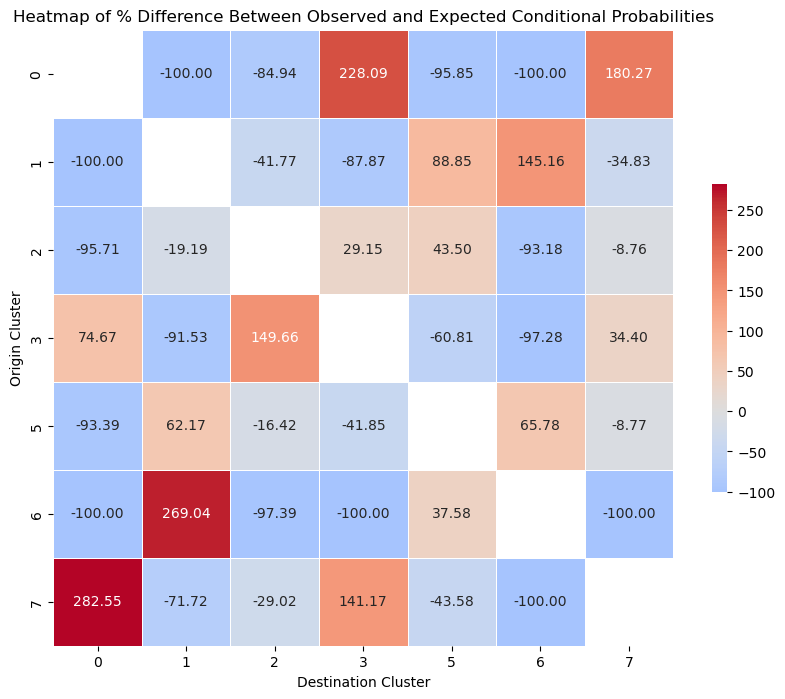

In [43]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
ax = sns.heatmap(perc_diff_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
                 linewidths=.5, cbar_kws={"shrink": .5})

# Title and labels (modify as needed)
plt.title('Heatmap of % Difference Between Observed and Expected Conditional Probabilities')
plt.ylabel('Origin Cluster')
plt.xlabel('Destination Cluster')

# Show the plot
plt.show()

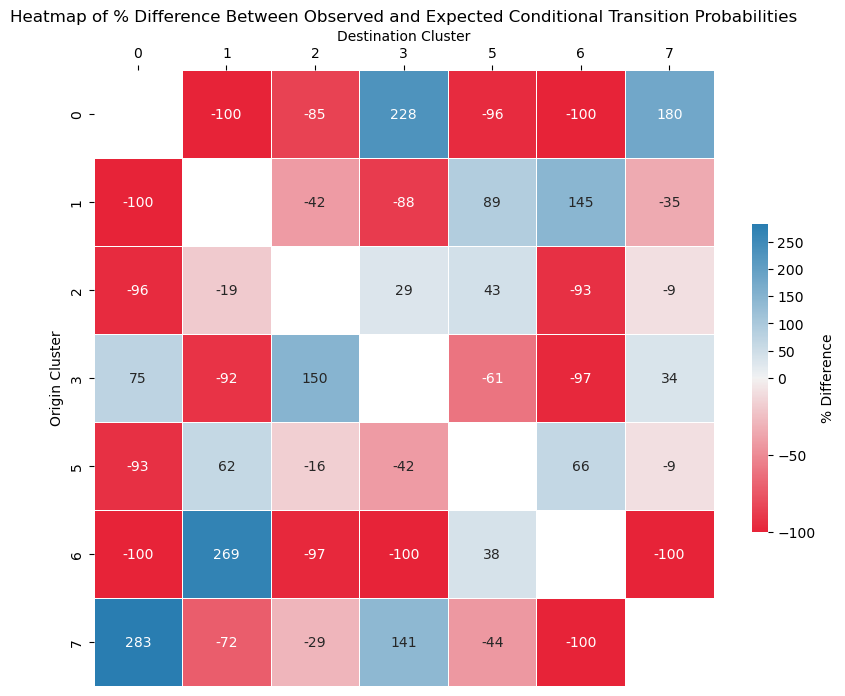

In [52]:
# Calculate differences
difference_matrix = observed_conditional_prob_matrix - exp_conditional_prob_matrix
perc_diff_matrix = (difference_matrix / exp_conditional_prob_matrix) * 100

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Dynamically adjust to the range of differences
vmax = max(100, np.max(perc_diff_matrix))
vmin = min(-100, np.min(perc_diff_matrix))

# Normalize the color scale so that -100 and vmax have equal intensity
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Custom color map, with equally saturated ends
cmap = sns.diverging_palette(10, 240, s=90, l=50, n=7, as_cmap=True)

# Draw the heatmap
ax = sns.heatmap(perc_diff_matrix, annot=True, fmt=".0f", cmap=cmap, norm=norm,
                 linewidths=.5, cbar_kws={"shrink": .5, "label": '% Difference'})

# Title and labels
plt.title('Heatmap of % Difference Between Observed and Expected Conditional Transition Probabilities')
plt.ylabel('Origin Cluster')

# Move the x-axis labels to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel('Destination Cluster')

# Show the plot
plt.show()